In [57]:
# === Análise e Preparação de Dados do E-commerce Brasileiro (Olist) ===

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlite3
import os

# Importação de dados
customers = pd.read_csv('/content/olist_customers_dataset.csv')
geolocation = pd.read_csv('/content/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/content/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')
sellers = pd.read_csv('/content/olist_sellers_dataset.csv')
product_category = pd.read_csv('/content/product_category_name_translation.csv')


# Remover duplicatas
customers.drop_duplicates(inplace=True)
geolocation.drop_duplicates(inplace=True)
order_items.drop_duplicates(inplace=True)
order_payments.drop_duplicates(inplace=True)
order_reviews.drop_duplicates(inplace=True)
orders.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
sellers.drop_duplicates(inplace=True)
product_category.drop_duplicates(inplace=True)

# Tratar valores nulos em datas
orders['order_approved_at'] = orders['order_approved_at'].fillna(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = orders['order_delivered_customer_date'].fillna(orders['order_estimated_delivery_date'])

# Tratar valores nulos em produtos
products['product_weight_g'] = products['product_weight_g'].fillna(products['product_weight_g'].mean())
products['product_length_cm'] = products['product_length_cm'].fillna(products['product_length_cm'].mean())
products['product_height_cm'] = products['product_height_cm'].fillna(products['product_height_cm'].mean())
products['product_width_cm'] = products['product_width_cm'].fillna(products['product_width_cm'].mean())


# Traduzir categorias de produto
products = products.merge(product_category, how='left', on='product_category_name')

# Normalizar texto
customers['customer_state'] = customers['customer_state'].str.upper()

# Converter colunas de data
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Conectar a banco em memória
conn = sqlite3.connect(':memory:')

# Salvar tabelas no banco
customers.to_sql('customers', conn, index=False)
geolocation.to_sql('geolocation', conn, index=False)
order_items.to_sql('order_items', conn, index=False)
order_payments.to_sql('order_payments', conn, index=False)
order_reviews.to_sql('order_reviews', conn, index=False)
orders.to_sql('orders', conn, index=False)
products.to_sql('products', conn, index=False)
sellers.to_sql('sellers', conn, index=False)
product_category.to_sql('product_category', conn, index=False)



71

In [63]:
# a) volume de pedidos por mes, existe uma sazonalidade sutil

query="""
SELECT strftime('%Y-%m', order_purchase_timestamp) AS month, COUNT(*) AS total_orders
FROM orders
GROUP BY month
ORDER BY month
"""

orders_monthly = pd.read_sql_query(query, conn)

px.line(orders_monthly, x='month', y='total_orders', title='Pedidos por Mês')

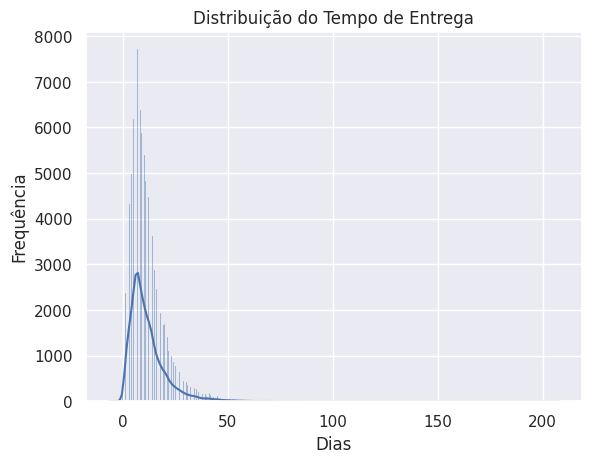

In [10]:
# b) tempo de entrega

orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_approved_at']).dt.days
sns.histplot(orders['delivery_time'].dropna(), kde=True)
plt.title('Distribuição do Tempo de Entrega')
plt.xlabel('Dias')
plt.ylabel('Frequência')
plt.show()

Text(0.5, 1.0, 'Valor do Frete X Quantidade de Itens')

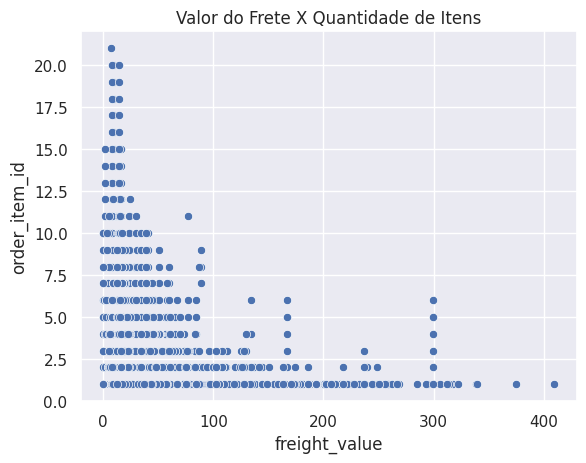

In [55]:
# c) valor do frete X distancia

#média por pedido
merged = orders.merge(order_items, on='order_id').merge(customers, on='customer_id')
freight_by_order = merged.groupby('order_id')[['freight_value']].mean().reset_index()

# simula a distancia aproximada com o geolation

sns.scatterplot(x='freight_value', y='order_item_id', data=order_items)
plt.title('Valor do Frete X Quantidade de Itens')

In [25]:
# d) Categorias mais lucrativas

query = """
SELECT p.product_category_name, SUM(oi.price) as revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY revenue DESC
LIMIT 10
"""
top_categories = pd.read_sql_query(query, conn)
px.bar(top_categories, x='product_category_name', y='revenue', title='Top 10 Categorias por Faturamento')


In [28]:
# e) Valor médio por estado

query = """
SELECT c.customer_state, AVG(oi.price + oi.freight_value) as avg_order_value
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_state
ORDER BY avg_order_value DESC
"""
avg_state = pd.read_sql_query(query, conn)
px.bar(avg_state, x='customer_state', y='avg_order_value', title='Valor Médio por Estado')


In [21]:
# Retenção de clientes

retention = orders.groupby('customer_id')['order_id'].nunique().reset_index()
retention['recorrente'] = retention['order_id'] > 1
retention_rate = retention['recorrente'].mean()
print(f"Taxa de clientes recorrentes: {retention_rate:.2%}")


Taxa de clientes recorrentes: 0.00%


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18325
           1       0.98      0.91      0.95      1564

    accuracy                           0.99     19889
   macro avg       0.99      0.96      0.97     19889
weighted avg       0.99      0.99      0.99     19889



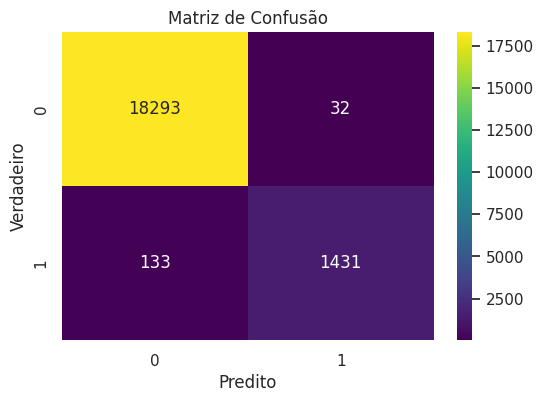

In [61]:


# Remover pedidos sem datas de entrega
orders = orders.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])

# Converter datas
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Criar variável target: 1 = atraso, 0 = no prazo
orders['is_late'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)

# Criar features de tempo
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders['estimated_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.days

# Merge com estado do cliente
orders = orders.merge(customers[['customer_id', 'customer_state']], on='customer_id')

# One-hot encoding do estado
orders = pd.get_dummies(orders, columns=['customer_state'], drop_first=True)

# SELEÇÃO DE FEATURES E TARGET
features = ['delivery_time', 'estimated_time'] + [col for col in orders.columns if 'customer_state_' in col]
X = orders[features]
y = orders['is_late']

# DIVISÃO EM TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODELO (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# AVALIAÇÃO DO MODELO
print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()


<Axes: xlabel='cluster', ylabel='recency'>

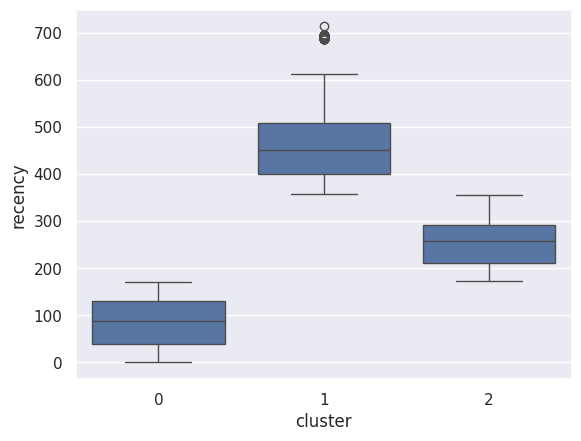

In [34]:
# segmentação de clientes

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

client_orders = orders.groupby('customer_id').agg({
    'order_id': 'count',
    'order_purchase_timestamp': ['min', 'max']
}).reset_index()

client_orders.columns = ['customer_id', 'n_orders', 'first_purchase', 'last_purchase']
client_orders['recency'] = (orders['order_purchase_timestamp'].max() - client_orders['last_purchase']).dt.days

X_seg = client_orders[['n_orders', 'recency']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
client_orders['cluster'] = kmeans.labels_

sns.boxplot(x='cluster', y='recency', data=client_orders)


Text(0.5, 1.0, 'Review Score vs Tempo de Entrega')

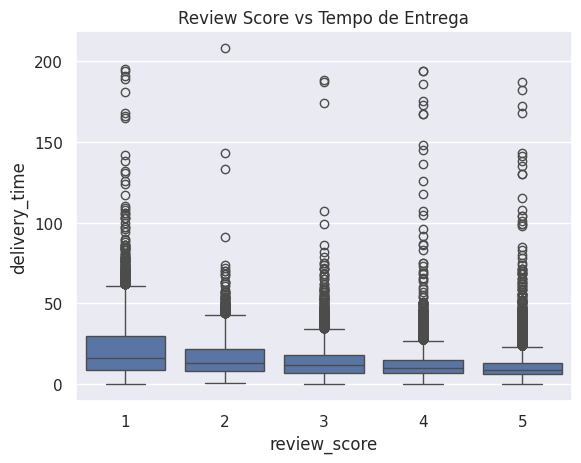

In [35]:
# análise de satisfação

reviews = order_reviews.merge(orders, on='order_id')
sns.boxplot(x='review_score', y='delivery_time', data=reviews)
plt.title("Review Score vs Tempo de Entrega")


In [36]:
fig = px.scatter(orders, x='order_purchase_timestamp', y='delivery_time',
                 color='order_status', title='Tempo de Entrega ao Longo do Tempo')
fig.show()


In [56]:


import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Inicializar app
app = dash.Dash(__name__)
app.title = 'Dashboard Olist'

# Layout com abas
app.layout = html.Div([
    html.H1("Dashboard E-commerce Brasileiro (Olist)", style={'textAlign': 'center'}),
    dcc.Tabs(id="tabs", value='tab1', children=[
        dcc.Tab(label='1. Evolução das Vendas', value='tab1'),
        dcc.Tab(label='2. Vendas por Estado', value='tab2'),
        dcc.Tab(label='3. Avaliação x Entrega', value='tab3'),
        dcc.Tab(label='4. Desempenho dos Vendedores', value='tab4'),
    ]),
    html.Div(id='tabs-content')
])

# Callbacks para renderizar cada aba
@app.callback(Output('tabs-content', 'children'),
              Input('tabs', 'value'))
def render_content(tab):
    if tab == 'tab1':
        return dcc.Graph(figure=fig1)
    elif tab == 'tab2':
        return dcc.Graph(figure=fig2)
    elif tab == 'tab3':
        import plotly.graph_objects as go
        # Boxplot com Plotly (adaptado do seaborn para compatibilidade)
        delivery_box = px.box(merged, x='review_score', y='delivery_time',
                              title="Tempo de Entrega vs Avaliação do Cliente",
                              labels={'review_score': 'Nota', 'delivery_time': 'Dias de Entrega'})
        return dcc.Graph(figure=delivery_box)
    elif tab == 'tab4':
        return dcc.Graph(figure=fig4)

# Rodar app
if __name__ == '__main__':
    app.run(debug=True)



<IPython.core.display.Javascript object>